라이브러리

In [2]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name1 = 'Test230718_tank1_lstm_all'
model_name2 = 'Test230717_tank1_lstm_crop_only-feed_no180'

In [3]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [4]:
#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")

In [5]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [6]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_validation_sensor_val_tb = japonica_validation_sensor_val[japonica_validation_sensor_val['tank_id']==tank]

#시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


/tmp/ipykernel_414568/778596347.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
/tmp/ipykernel_414568/778596347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
/tmp/ipykernel_414568/778596347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [7]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [8]:
japonica_validation_features_X_a = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_X_b = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

모델 평가

In [9]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('x')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)
    
def grapeNEva3(model1, model2, y_test, X_test_shape1, y_test_shape1, X_test_shape2, y_test_shape2,feed):
    X_pred1 = model1.predict(X_test_shape1)
    X_pred1 = np.asarray(X_pred1, dtype=np.float64)
    X_pred1 = X_pred1.reshape((-1))
    print(len(X_pred1))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred1, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name1)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model1.evaluate(X_test_shape1, y_test_shape1)
    print("MSE // MAE // R-squared ", result)

    X_pred2 = model2.predict(X_test_shape2)
    X_pred2 = np.asarray(X_pred2, dtype=np.float64)
    X_pred2 = X_pred2.reshape((-1))
    print(len(X_pred2))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred2, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name2)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model2.evaluate(X_test_shape2, y_test_shape2)
    print("MSE // MAE // R-squared ", result)
    
    weight_a = 0.5
    weight_b = 0.5
    final_predictions = weight_a * X_pred1 + weight_b * X_pred2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('add')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = (X_pred1 + X_pred2)/2
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('average')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    final_predictions = X_pred1 * (X_pred2 / 8.50096798)
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('multi')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    diff = X_pred1 - X_pred2
    final_predictions = X_pred1 + diff
    
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, final_predictions, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title('diff')
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()

In [10]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model1 = load_model(model_name1+'.h5', custom_objects={'r_squared': r_squared})
model2 = load_model(model_name2+'.h5', custom_objects={'r_squared': r_squared})

2023-07-21 11:01:14.560429: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 11:01:15.856042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 479 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


[[-0.05434919 -0.03929733  0.17777887 ... -0.02205533  0.04580057
  -0.5461169 ]
 [ 0.03374866  0.10543419  0.11074062 ...  0.10027533  0.09589972
   0.04831497]
 [ 0.09673794 -0.0601322   0.0851886  ...  0.07200366 -0.02557736
   0.19047226]
 ...
 [-0.09746638 -0.04611877  0.08885422 ...  0.08605042 -0.05946188
   0.06224105]
 [ 0.02099556 -0.09167597  0.03627907 ... -0.05459717 -0.05522252
  -0.04373736]
 [ 0.06351736  0.00746651 -0.05043005 ...  0.09771328 -0.08418127
  -0.16216135]]


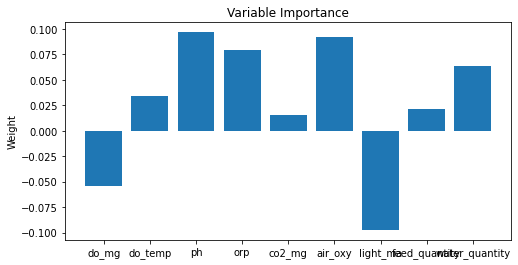

[[-4.72663268e-02 -1.83262378e-01 -2.80944705e-01 -5.30997254e-02
   4.97256070e-02 -7.10335299e-02 -5.46848699e-02 -8.50662775e-03
  -3.22581828e-02  3.67322266e-02 -3.75255309e-02 -1.25029758e-02
  -2.90096164e-01  1.19099924e-02 -1.74790189e-01  8.06833208e-02
  -1.71592221e-01  9.38826278e-02 -7.67420977e-02 -9.59455296e-02
  -2.74989337e-01 -7.85937458e-02  1.08334355e-01  6.76013529e-02
  -1.31007433e-01 -8.90544578e-02 -1.26921639e-01  2.73740590e-02
  -8.91414564e-03 -3.25342044e-02 -2.77821682e-02 -4.60928492e-02
  -2.07575664e-01  1.42898709e-02 -1.37847796e-01 -1.23360097e-01
  -5.04630916e-02 -1.06947906e-01 -2.21359193e-01 -1.86189801e-01
  -2.68812478e-01 -2.50464290e-01 -1.74484164e-01 -5.50884604e-02
  -5.56164794e-02 -7.98808783e-02 -2.65284717e-01 -2.23425046e-01
   7.17013180e-02 -1.82262957e-01 -1.14264928e-01 -2.35341880e-02
  -7.20075890e-02 -9.17396918e-02 -1.71415228e-02 -8.44757408e-02
  -2.61861622e-01  4.10829633e-02  2.13904418e-02 -2.29482681e-01
   1.08574

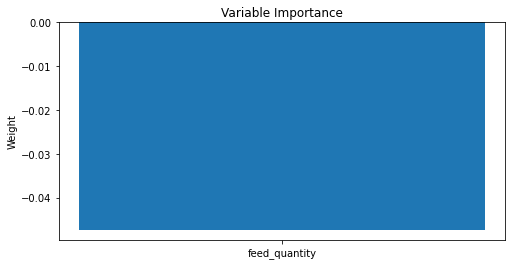

In [11]:
# 가중치를 통해 변수 중요도 획득
weights = model1.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

# 가중치를 통해 변수 중요도 획득
weights = model2.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [12]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))


nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 351 nVar: 180
nCar: 63180 nVar: 1


In [13]:
X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 9
nCar: 351 nVar: 9


In [14]:
X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-09-08 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 63180 nVar: 1


In [15]:
grapeNEva3(model1, model2, y_test, X_test_reshape1, y_test_reshape1, X_test_reshape2, y_test_reshape2, X_test2[['feed_quantity']])

2023-07-21 11:01:28.552654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-21 11:01:31.718559: E tensorflow/stream_executor/cuda/cuda_dnn.cc:374] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-07-21 11:01:31.719548: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at cudnn_rnn_ops.cc:1555 : Unknown: Fail to find the dnn implementation.


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_4762]

Function call stack:
predict_function -> predict_function -> predict_function


In [1]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))


nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-31 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva3(model1, model2, y_test, X_test_reshape1, y_test_reshape1, X_test_reshape2, y_test_reshape2, X_test2[['feed_quantity']])

NameError: name 'japonica_validation_features_y' is not defined

In [ ]:
y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))


nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva3(model1, model2, y_test, X_test_reshape1, y_test_reshape1, X_test_reshape2, y_test_reshape2, X_test2[['feed_quantity']])

In [ ]:
japonica_validation_features_X_a.at['2021-07-22 08:00', 'feed_quantity'] = 6
japonica_validation_features_X_b.at['2021-07-22 08:00', 'feed_quantity'] = 6

y_date = japonica_validation_features_y.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape1 = y_test_reshape.reshape((-1, 180, 1))
y_test_reshape2 = y_test_reshape.reshape((-1, 1, 1))


nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape1.shape[0] # 데이터 개수
nVar = y_test_reshape1.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape2.shape[0] # 데이터 개수
nVar = y_test_reshape2.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test1 = japonica_validation_features_X_a.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape1 = np.asarray(X_test1, dtype=np.float64)
X_test_reshape1 = X_test_reshape1.reshape((-1, 180, 9))

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape1.shape[0] # 데이터 개수
nVar = X_test_reshape1.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

X_test2 = japonica_validation_features_X_b.loc['2021-07-22 03:00':'2021-07-22 23:59']

X_test_reshape2 = np.asarray(X_test2, dtype=np.float64)
X_test_reshape2 = X_test_reshape2.reshape((-1, 1, 1))


# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape2.shape[0] # 데이터 개수
nVar = X_test_reshape2.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva3(model1, model2, y_test, X_test_reshape1, y_test_reshape1, X_test_reshape2, y_test_reshape2, X_test2[['feed_quantity']])

In [ ]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

In [ ]:
japonica_validation_features_X.at['2021-07-22 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

X_test_reshape_a = X_test_reshape[:, :, 0].reshape((-1, 180, 1))
X_test_reshape_b = X_test_reshape[:, :, 1].reshape((-1, 180, 1))

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = X_test_reshape_a.shape[0] # 데이터 개수
nVar = X_test_reshape_b.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [9]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

NameError: name 'japonica_validation_features_X' is not defined

In [10]:
grapeNEva(model,[X_test_reshape_a, X_test_reshape_b], y_test, y_date[['feed_quantity']], y_test_reshape)

NameError: name 'grapeNEva' is not defined

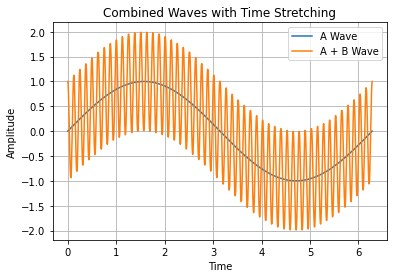

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# A 파형 생성 (넓고 주파수 낮음)
t_a = np.linspace(0, 2*np.pi, 1000)
amplitude_a = np.sin(t_a)

# B 파형 생성 (좁고 주파수 높음)
t_b = np.linspace(0, 2*np.pi, 100)
amplitude_b = np.cos(5*t_b)

# B 파형의 주기를 A 파형에 맞게 늘림
amplitude_b_resized = np.resize(amplitude_b, len(t_a))

# A 파형에 B 파형의 특징 추가
combined_wave = amplitude_a + amplitude_b_resized

# 그래프 그리기
plt.plot(t_a, amplitude_a, label='A Wave')
plt.plot(t_a, combined_wave, label='A + B Wave')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Combined Waves with Time Stretching')
plt.grid()
plt.show()